# (23) Amort-FF—0

**Motivation**: Amortized inference, with residual FF encoder. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## FF

In [3]:
kws_vae = dict(enc_type='mlp', enc_bias=True, rmax_q=1.0)
kws_tr = dict(kl_beta=1.0, method='mc')

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**kws_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**kws_tr), device=device)

In [4]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  2.4 Mil   |
|     ---     |    ---     |
|     enc     |  2.1 Mil   |
|    fc_enc   |  131.6 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_k-32_<mlp+b|lin>
mc_ep3600-b1000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)

In [5]:
vae.fc_dec.bias, vae.fc_enc.bias.shape

(None, torch.Size([512]))

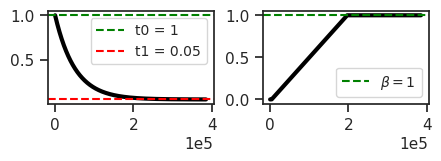

In [6]:
tr.show_schedules()

## Train

In [7]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3600, avg loss: 164.347325: 100%|█████████████████████| 3600/3600 [1:01:44<00:00,  1.03s/it]


In [9]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (enc): DenseResBlock(
    (fc1): Linear(in_features=256, out_features=4096, bias=True)
    (fc2): Linear(in_features=4096, out_features=256, bias=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.1, inplace=False)
    (relu): ReLU()
  )
  (fc_enc): Linear(in_features=256, out_features=512, bias=True)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

## Eval

### Loss vld (freeze)

In [10]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 134.43456, 'kl': 29.699905, 'kl_diag': 0.057496846, 'tot': 164.13446}

### Identify dead neurons

In [11]:
dead_thres = 0 # 0.002
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

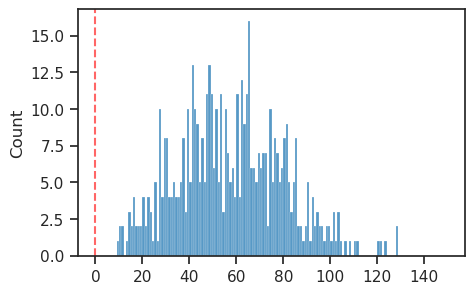

In [13]:
upper_lim = 150
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, upper_lim, upper_lim + 1))
ax.locator_params(axis='x', nbins=15)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
plt.show()

### Spike counts

In [14]:
lifetime, population, percents = sparse_score(data['z'], cutoff=0.01)
percents

{'0': 92.7, '1': 5.9, '2': 0.8, '3+': 0.5}

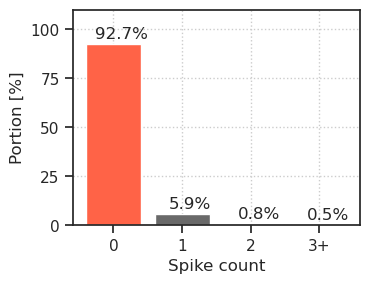

In [15]:
fig, ax = create_figure(1, 1, (3.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)

colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

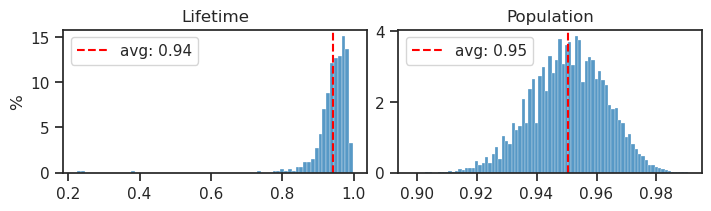

In [16]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [17]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(20.0, 93.0)

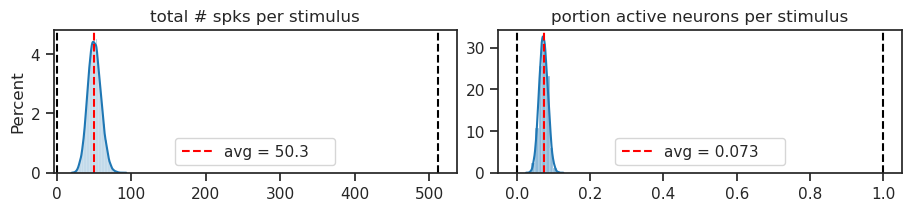

In [18]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

### Plot enc/dec weights

In [22]:
log_r8s = to_np(vae.log_rates.squeeze())
order = np.argsort(log_r8s)

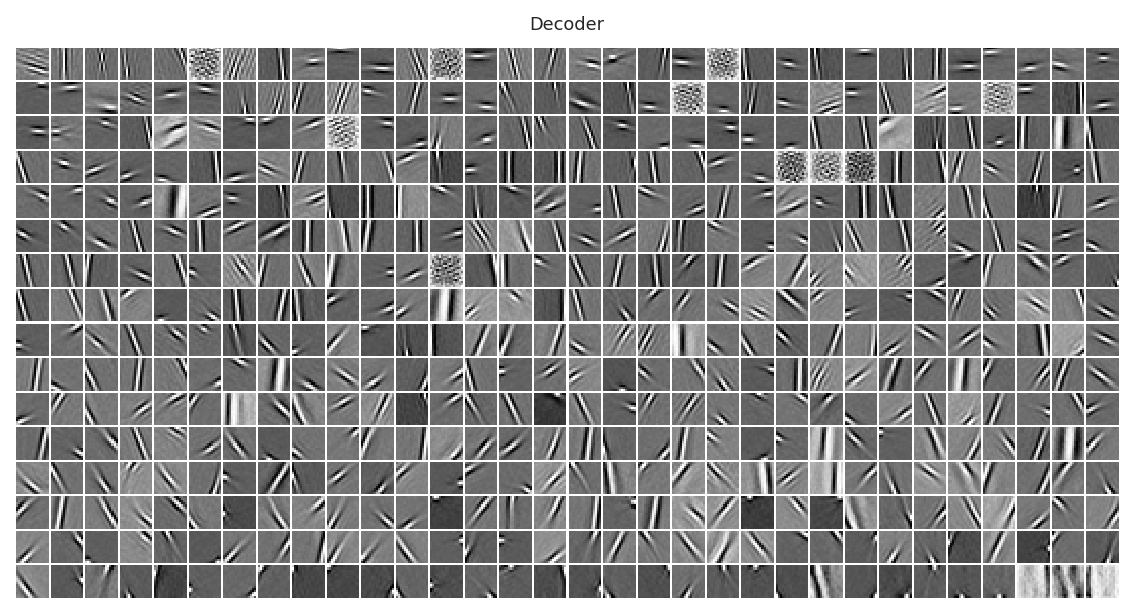

In [23]:
vae.show(order=order);

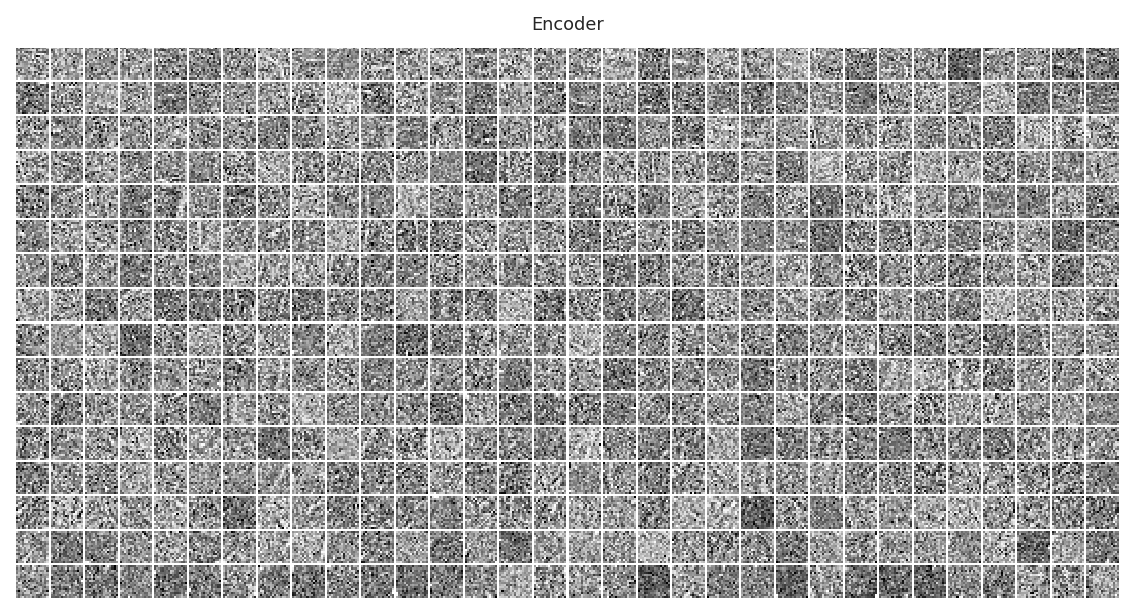

In [24]:
vae.show('enc', order=order);

#### Order according to kl_diag

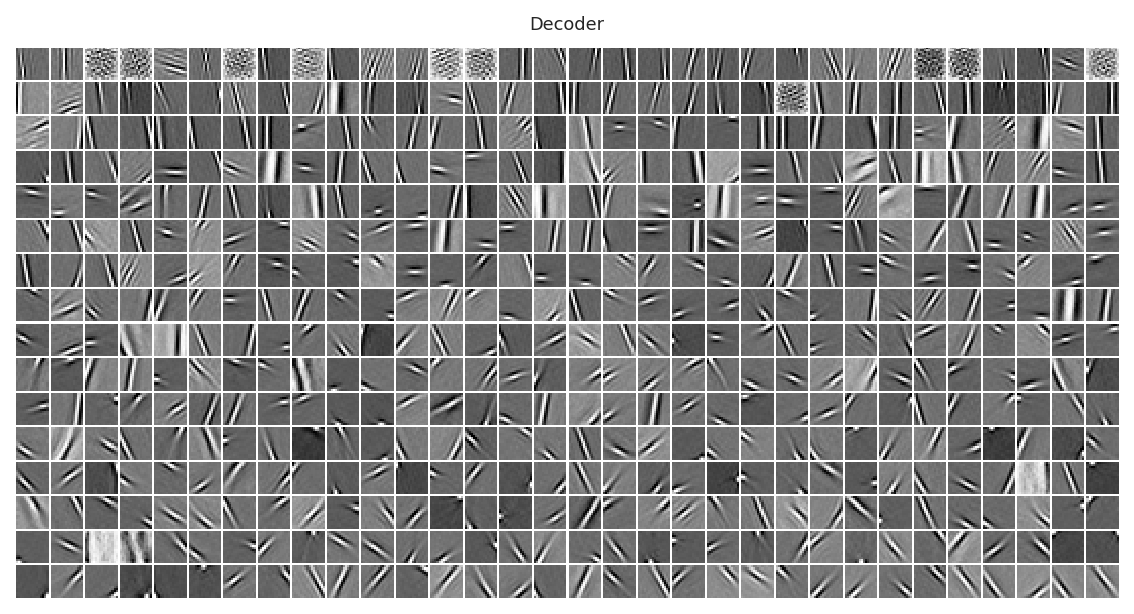

In [75]:
vae.show(order=np.argsort(loss['kl_diag']));

### Some more distributions

In [25]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0505, device='cuda:0'), 1.0)

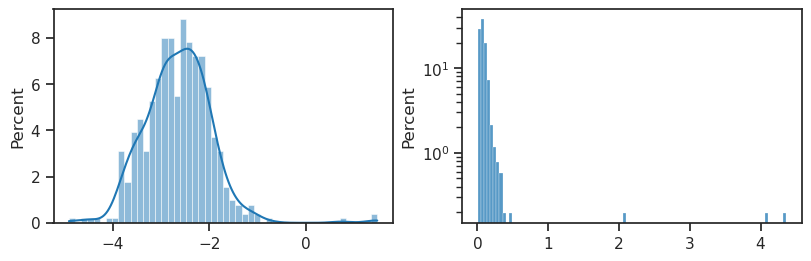

In [26]:
prior_rates = to_np(vae.log_rates)[:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(prior_rates, stat='percent', bins=50, kde=True, ax=axes[0])
sns.histplot(np.exp(prior_rates), stat='percent', bins=100, ax=axes[1])
axes[1].set_yscale('log')
plt.show()

In [27]:
prior_rates = to_np(vae.log_rates)[:, ~dead].ravel()

mu = prior_rates.mean()
sd = prior_rates.std()

rv = sp_stats.norm(loc=mu, scale=sd)
xs = np.linspace(-5.1, 2.4, 100)
pdf = rv.pdf(xs)

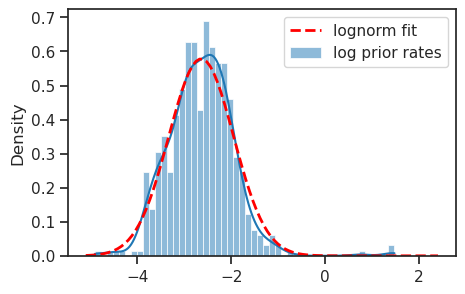

In [28]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=50, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

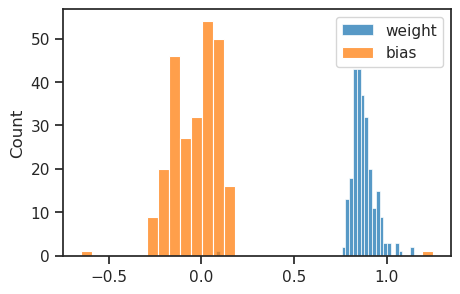

In [29]:
sns.histplot(to_np(vae.enc.layer_norm.weight), label='weight')
sns.histplot(to_np(vae.enc.layer_norm.bias), label='bias')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

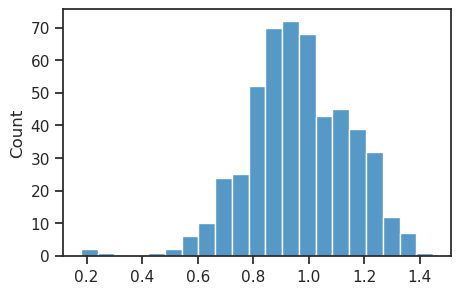

In [30]:
sns.histplot(to_np(torch.norm(vae.fc_dec.weight, dim=0)))

In [34]:
select = to_np(vae.log_rates.exp().squeeze()) > 2
select.sum()

3

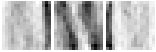

In [40]:
from figures.weight import plot_weights

_ = plot_weights(
    vae.fc_dec.weight.data[:, select].T.reshape(-1, 16, 16),
    nrows=1,
    dpi=20,
)

## Log-gabor

In [41]:
from analysis.eval import fit_loggabor
from figures.theta import plot_theta

In [42]:
results = fit_loggabor(tr, verbose=True)

 68%|███████▌   | 350/512 [00:12<00:05, 29.86it/s]

 90%|█████████▊ | 459/512 [00:16<00:01, 30.26it/s]

100%|███████████| 512/512 [00:18<00:00, 27.82it/s]


In [43]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,506.000000,5.060000e+02,506.000000,504.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,7.412846,7.564851e+00,0.037421,0.310636,-0.060264,0.555290,0.306564,90.009652,0.105195
std,3.722129,4.260105e+00,0.992844,0.443229,0.952995,0.310084,0.404341,48.368580,0.279722
min,0.396723,1.038272e-07,-1.570796,0.082405,-2.850084,0.150969,0.074027,0.157265,0.007411
25%,4.766874,3.729638e+00,-0.897518,0.228089,-0.655620,0.435430,0.144557,51.180765,0.047139
50%,7.390167,7.660584e+00,0.044040,0.248429,-0.138588,0.490794,0.222231,90.000000,0.073611
75%,9.925719,1.129055e+01,0.923920,0.281676,0.537989,0.581811,0.337613,126.862178,0.108918
max,14.665210,1.543329e+01,1.570796,7.099060,3.760017,5.282411,6.605471,179.930470,4.361912


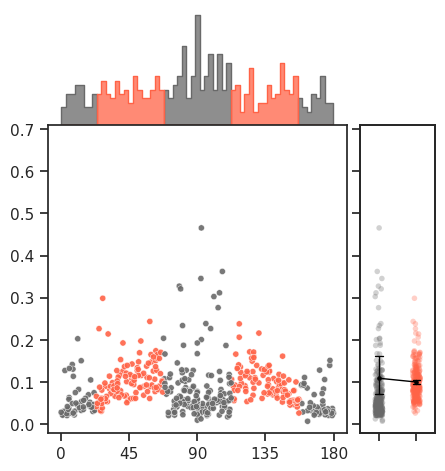

In [44]:
fig, _ = plot_theta(results)

In [49]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

rates_axial.mean(), rates_oblique.mean()

(0.10930975, 0.100373566)

In [52]:
len(rates_axial), len(rates_oblique)

(273, 233)

In [53]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')

MannwhitneyuResult(statistic=15987.0, pvalue=4.997002419547376e-22)

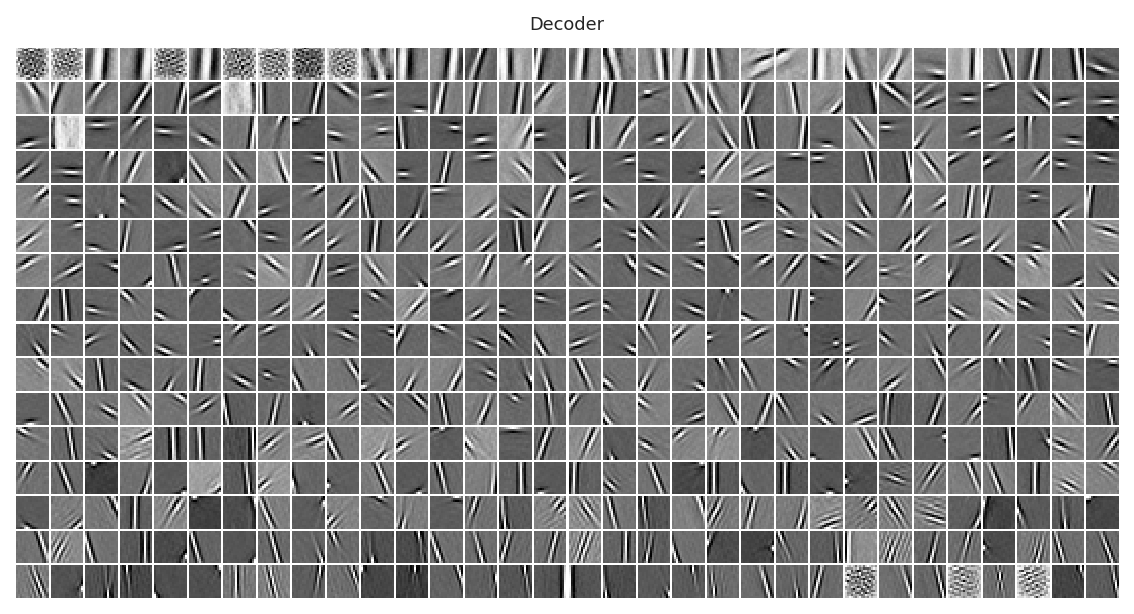

In [55]:
order = np.argsort(results['sf_0'].values)
_ = vae.show(order=order)

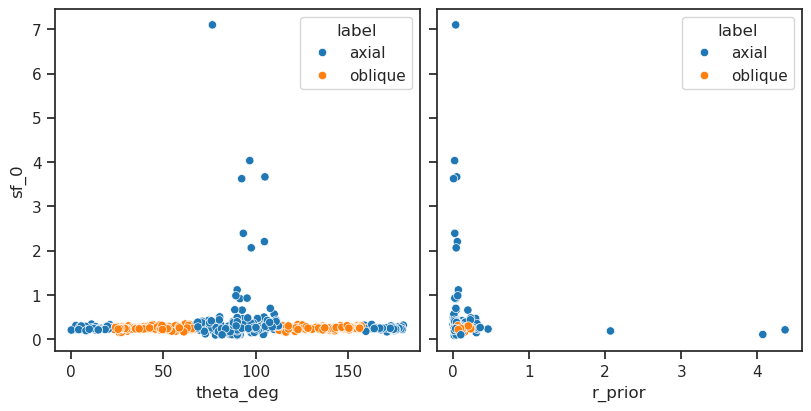

In [56]:
fig, axes = create_figure(1, 2, (8, 4), sharey='row', layout='constrained')
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', ax=axes[0])
sns.scatterplot(data=results, y='sf_0', x='r_prior', hue='label', ax=axes[1])
plt.show()

## Remove the dead?

In [66]:
results = fit_loggabor(tr, verbose=True)

 69%|███████▌   | 352/512 [00:12<00:05, 31.44it/s]

 90%|█████████▊ | 459/512 [00:16<00:01, 38.69it/s]

100%|███████████| 512/512 [00:18<00:00, 28.22it/s]


In [70]:
dead = results['r_prior'].values > 1
dead.sum()

3

In [71]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,503.000000,5.030000e+02,503.000000,501.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,7.419040,7.567419e+00,0.034029,0.311494,-0.072056,0.556118,0.307674,89.981541,0.084940
std,3.727804,4.249753e+00,0.989223,0.444405,0.939626,0.310567,0.405279,48.508767,0.056462
min,0.396723,1.038272e-07,-1.570796,0.082405,-2.850084,0.150969,0.074027,0.157265,0.007411
25%,4.768236,3.739390e+00,-0.893471,0.228592,-0.659643,0.436245,0.144789,51.063466,0.047113
50%,7.385012,7.671576e+00,0.042174,0.248623,-0.154149,0.490838,0.222605,90.000000,0.073360
75%,9.959717,1.127217e+01,0.921390,0.283489,0.532703,0.581791,0.338187,127.040306,0.108361
max,14.665210,1.543329e+01,1.570796,7.099060,3.760017,5.282411,6.605471,179.930470,0.465639


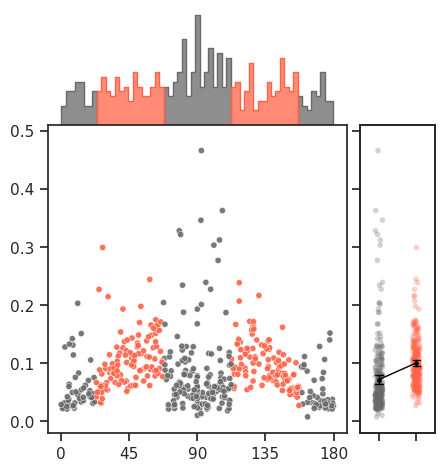

In [74]:
fig, _ = plot_theta(results, ylim=(-0.02, 0.51))